In [1]:
#### TEST ON THREE INPUTS AND THREE OUTPUTS

Vocabulary: ['<END>', '<PAD>', '<START>', '<UNK>', 'am', 'are', 'coding', 'eating', 'i', 'sleeping', 'they', 'you']
Vocabulary Size: 12
Epoch 1 Summary: Average Loss = 4.4008, Accuracy = 0.00
Epoch 2 Summary: Average Loss = 4.8491, Accuracy = 0.00
Epoch 3 Summary: Average Loss = 4.7932, Accuracy = 0.00
Epoch 4 Summary: Average Loss = 4.7258, Accuracy = 0.00
Epoch 5 Summary: Average Loss = 4.6540, Accuracy = 0.00
Epoch 6 Summary: Average Loss = 4.5803, Accuracy = 0.00
Epoch 7 Summary: Average Loss = 4.5060, Accuracy = 0.00
Epoch 8 Summary: Average Loss = 4.4314, Accuracy = 0.00
Epoch 9 Summary: Average Loss = 4.3571, Accuracy = 0.00
Epoch  | Original Input                 | Padded Tokens                                      | Padded IDs                          | Target     | Target ID  | Predicted  | Predicted ID | Loss         | Correct Prediction  
-----------------------------------------------------------------------------------------------------------------------------------------

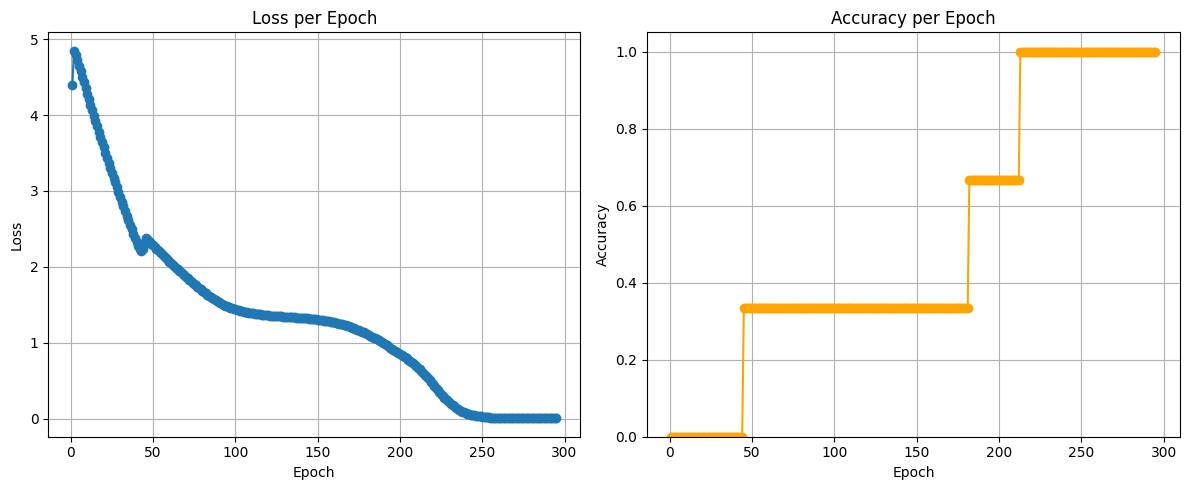

In [2]:
import numpy as np
import math
import os
from collections import OrderedDict
import matplotlib.pyplot as plt

# --- Configuration ---

input_sentences = ["i am", "you are", "they are"]
output_targets = ["sleeping", "eating", "coding"]
# input_sentences = [
#     "i am", "they are", "she is", "we are", "you are", "he is",
#     "it is", "i was", "they were", "we will", "you will", "he was",
#     "she was", "i will", "they will", "we were", "he is not here"
#     "we are going to", "you might be", "they could be",
#     "i should have been", "you would be", "he shall be walking",
#     "they will have been", "we might have been", "he was going to be",
#     "she is currently", "i am still", "they are definitely", "you were probably",
#     "we could have", "he will likely", "she might", "i will probably",
#     "they were already", "we are soon", "you are still", "he was just",
#     "she will surely", "i have been", "you had been", "he could be",
#     "they might", "we were likely", "i was definitely", "she was just",
#     "you are going to", "they have been", "we might be", "i could be",
#     "she might have", "you shall be", "they are going to", "he was planning to",
#     "we will be", "i am about to", "you were supposed to", "she was about to",
#     "they are about to", "we are ready to", "he is expected to", "she is trying to",
#     "you might want to", "i feel like", "they seem to be", "we hope to",
#     "he pretends to", "she wants to", "i think i will", "you think you will",
#     "they believe they will", "we assume we are", "he guesses he will", "she imagines she will",
#     "i pretend to", "you imagine you will", "they plan to", "we are planning to",
#     "he has decided to", "she intends to", "i am learning to", "you are starting to",
#     "they are beginning to", "we are trying to", "he wants to start", "she is ready to",
#     "i feel ready to", "you are expected to", "they are willing to", "we are prepared to",
#     "he is committed to", "she is determined to", "i hope to", "you plan to",
#     "they should", "we could", "he must", "she might want to",
#     "i am going to", "you are going to", "we would be",
# ][:25]
# output_targets = [
#     "sleeping", "playing", "dancing", "walking", "talking", "eating",
#     "drawing", "reading", "coding", "running", "jumping", "writing",
#     "building", "painting", "traveling", "learning", "talking",
#     "dancing", "walking", "sleeping",
#     "reading", "coding", "running", "jumping", "writing", "building",
#     "painting", "traveling", "learning", "reading",
#     "talking", "dancing", "walking", "sleeping", "playing", "dancing",
#     "walking", "talking", "eating", "drawing", "reading", "coding",
#     "running", "jumping", "writing", "building", "painting", "traveling",
#     "learning", "reading", "talking", "dancing", "walking", "sleeping",
#     "playing", "dancing", "walking", "talking", "eating", "drawing",
#     "reading", "coding", "running", "jumping", "writing", "building",
#     "painting", "traveling", "learning", "reading", "talking", "dancing",
#     "walking", "sleeping", "playing", "dancing", "walking", "talking",
#     "eating", "drawing", "reading", "coding", "running", "jumping",
#     "writing", "building", "painting", "traveling", "learning", "reading",
#     "talking", "dancing", "walking", "sleeping", "playing", "dancing",
#     "walking", "talking", "eating", "drawing"
# ][:25]

assert len(input_sentences)==len(output_targets)

embedding_dim = 512  # Keeping original embedding dimension
learning_rate = 0.01
num_epochs = 5000 # Increased epochs to ensure overfitting on small data

# --- Helper Functions ---

def clip_gradient(grad, threshold=1.0):
    """Clips gradients to prevent exploding gradients."""
    norm = np.linalg.norm(grad)
    if norm > threshold:
        return grad * (threshold / (norm + 1e-6))
    return grad

def softmax(x, axis=-1):
    """Computes softmax probabilities."""
    # Subtract max for numerical stability
    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class LayerNormalization:
    """
    Implements Layer Normalization.
    Reference: https://arxiv.org/abs/1607.06450
    """
    def __init__(self, features_dim):
        self.gamma = np.ones(features_dim)
        self.beta = np.zeros(features_dim)
        self.eps = 1e-9

        # Stored for backward pass
        self.mean = None
        self.variance = None
        self.x_normalized = None
        self.x_input = None
        self.features_dim = features_dim # Store features_dim explicitly

    def forward(self, x):
        self.x_input = x
        self.mean = np.mean(x, axis=-1, keepdims=True)
        self.variance = np.var(x, axis=-1, keepdims=True)
        self.x_normalized = (x - self.mean) / np.sqrt(self.variance + self.eps)
        return self.gamma * self.x_normalized + self.beta

    def backward(self, dout):
        # Gradients for beta and gamma
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(dout * self.x_normalized, axis=0)

        # Gradient for x_normalized
        dx_normalized = dout * self.gamma

        # Number of elements in the dimension over which mean/variance was computed
        # For LayerNorm, this is typically the feature dimension (embedding_dim)
        N = self.features_dim

        # Gradient of variance
        d_var = np.sum(dx_normalized * (self.x_input - self.mean), axis=-1, keepdims=True) * (-0.5 * (self.variance + self.eps)**(-1.5))

        # Gradient of mean
        d_mean = np.sum(dx_normalized * (-1.0 / np.sqrt(self.variance + self.eps)), axis=-1, keepdims=True) + \
                 d_var * np.sum(-2.0 * (self.x_input - self.mean) / N, axis=-1, keepdims=True)

        # Gradient of x
        dx = dx_normalized / np.sqrt(self.variance + self.eps) + \
             d_var * (2.0 * (self.x_input - self.mean) / N) + \
             d_mean / N

        return dx, dgamma, dbeta

def positional_encoding(sequence_length, embedding_dim):
    """
    Computes positional encodings for a sequence.
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    position_enc = np.zeros((sequence_length, embedding_dim))
    for pos in range(sequence_length):
        for i in range(embedding_dim):
            denominator = 10000 ** (i / embedding_dim)
            if i % 2 == 0:
                position_enc[pos, i] = math.sin(pos / denominator)
            else:
                position_enc[pos, i] = math.cos(pos / denominator)
    return position_enc

# --- Model Components (Simplified for this example) ---

class SelfAttention:
    """Single head self-attention mechanism."""
    def __init__(self, embedding_dim, sequence_length):
        # Initialize weights for Query, Key, Value, and Output projection
        self.WQ = np.random.randn(embedding_dim, embedding_dim) * 0.01
        self.WK = np.random.randn(embedding_dim, embedding_dim) * 0.01
        self.WV = np.random.randn(embedding_dim, embedding_dim) * 0.01
        self.W0 = np.random.randn(embedding_dim, embedding_dim) * 0.01 # Output projection

        # Stored for backward pass
        self.Q = None
        self.K = None
        self.V = None
        self.scores = None
        self.weights = None
        self.attention = None
        self.X_input = None # Store input X for backward pass

    def forward(self, X):
        self.X_input = X # Store original input
        self.Q = X @ self.WQ
        self.K = X @ self.WK
        self.V = X @ self.WV

        # Scaled Dot-Product Attention
        self.scores = (self.Q @ self.K.T) / np.sqrt(embedding_dim) # Using embedding_dim as d_k
        self.weights = softmax(self.scores, axis=-1)
        self.attention = self.weights @ self.V

        # Output projection
        attention_out = self.attention @ self.W0
        return attention_out

    def backward(self, dout_attention_out):
        # Gradients for W0X
        dW0 = self.attention.T @ dout_attention_out

        # Gradient for attention
        dout_attention = dout_attention_out @ self.W0.T

        # Gradients for V and weights
        dV = self.weights.T @ dout_attention
        dweights = dout_attention @ self.V.T

        # Gradient for scores (softmax backward)
        dscores = dweights * self.weights
        sum_dscores = np.sum(dscores, axis=-1, keepdims=True)
        dscores -= self.weights * sum_dscores
        dscores /= np.sqrt(embedding_dim) # Divide by sqrt(d_k) from forward pass

        # Backprop through scores = (Q @ K.T) / sqrt(d_k)
        # Let S_unscaled = Q @ K.T
        d_S_unscaled = dscores * np.sqrt(embedding_dim)

        # For S_unscaled = Q @ K.T:
        # dL/dQ = dL/dS_unscaled @ K.T.T = dL/dS_unscaled @ K
        # dL/dK = (Q.T @ dL/dS_unscaled).T = dL/dS_unscaled.T @ Q
        dQ = d_S_unscaled @ self.K
        dK = d_S_unscaled.T @ self.Q

        # Gradients for WQ, WK, WV
        dWQ = self.X_input.T @ dQ
        dWK = self.X_input.T @ dK
        dWV = self.X_input.T @ dV

        # Gradient for X (input to attention)
        dX = dQ @ self.WQ.T + dK @ self.WK.T + dV @ self.WV.T

        # Clip gradients before returning
        dWQ = clip_gradient(dWQ)
        dWK = clip_gradient(dWK)
        dWV = clip_gradient(dWV)
        dW0 = clip_gradient(dW0)
        dX = clip_gradient(dX)

        return dX, dWQ, dWK, dWV, dW0

class FeedForwardNetwork:
    """Simple two-layer feed-forward network with ReLU activation."""
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros(output_dim)

        # Stored for backward pass
        self.in_for_relu = None
        self.FFN_hidden = None
        self.input_X = None # Store input X for backward pass

    def forward(self, X):
        self.input_X = X
        self.in_for_relu = X @ self.W1 + self.b1
        self.FFN_hidden = np.maximum(0, self.in_for_relu) # ReLU activation
        FFN_output = self.FFN_hidden @ self.W2 + self.b2
        return FFN_output

    def backward(self, dout_ffn_output):
        # Gradients for W2 and b2
        dW2 = self.FFN_hidden.T @ dout_ffn_output
        db2 = np.sum(dout_ffn_output, axis=0)

        # Gradient for FFN_hidden (before ReLU)
        dout_ffn_hidden = dout_ffn_output @ self.W2.T

        # Gradient for in_for_relu (ReLU backward)
        drelu = dout_ffn_hidden * (self.in_for_relu > 0).astype(float)

        # Gradients for W1 and b1
        dW1 = self.input_X.T @ drelu
        db1 = np.sum(drelu, axis=0)

        # Gradient for X (input to FFN)
        dX = drelu @ self.W1.T

        # Clip gradients before returning
        dW1 = clip_gradient(dW1)
        db1 = clip_gradient(db1)
        dW2 = clip_gradient(dW2)
        db2 = clip_gradient(db2)
        dX = clip_gradient(dX)

        return dX, dW1, db1, dW2, db2

# --- Transformer Model Class ---

class SimpleTransformer:
    def __init__(self, vocab, embedding_dim, hidden_dim):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Word embeddings
        self.word_to_vec = {word: np.random.randn(embedding_dim) * 0.01 for word in vocab}
        # Normalize embeddings
        for k in self.word_to_vec:
            self.word_to_vec[k] /= np.linalg.norm(self.word_to_vec[k]) + 1e-9

        # Model layers
        self.attention_layer = SelfAttention(embedding_dim, embedding_dim)
        self.norm1 = LayerNormalization(embedding_dim)
        self.ffn = FeedForwardNetwork(embedding_dim, hidden_dim, embedding_dim)
        self.norm2 = LayerNormalization(embedding_dim)

        # Output layer weights (projection from sentence vector to vocabulary logits)
        self.V_output = np.array([self.word_to_vec[word] for word in vocab])
        self.max_seq_len = 5 # Define max_seq_len here, consistent with forward

    def forward(self, input_text):
        words = input_text.split()

        # Store original length before padding
        original_input_len = len(words)

        # Pad or truncate to a fixed sequence length (e.g., 5 for simplicity)
        max_seq_len = self.max_seq_len
        if original_input_len < max_seq_len:
            words.extend(['<PAD>'] * (max_seq_len - original_input_len))
        elif original_input_len > max_seq_len:
            words = words[:max_seq_len]

        # Get embeddings for input words
        input_embeddings = np.array([self.word_to_vec[word] if word in self.word_to_vec else self.word_to_vec['<UNK>'] for word in words])

        # Add positional encoding
        pos_enc = positional_encoding(len(words), self.embedding_dim)
        X = input_embeddings + pos_enc

        # Encoder Block
        # Self-Attention
        attention_out = self.attention_layer.forward(X)

        # Add & Norm 1
        add_norm1_input = X + attention_out
        norm1_output = self.norm1.forward(add_norm1_input)

        # Feed Forward Network
        ffn_output = self.ffn.forward(norm1_output)

        # Add & Norm 2
        add_norm2_input = norm1_output + ffn_output
        norm2_output = self.norm2.forward(add_norm2_input)

        # Sentence vector: Average of non-padding token representations
        # Use original_input_len to average only actual input words
        if original_input_len > 0:
            sentence_vector = np.mean(norm2_output[:original_input_len], axis=0)
        else:
            sentence_vector = np.zeros(self.embedding_dim)

        # Final projection to vocabulary logits
        logits = self.V_output @ sentence_vector
        probs = softmax(logits)

        return probs, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, words # Return padded words

    def backward(self, probs, target_word, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, current_input_idx):
        target_index = self.vocab.index(target_word)

        # Initialize gradients for word embeddings
        d_word_to_vec = {word: np.zeros(self.embedding_dim) for word in self.vocab}

        # --- Gradients from Output Layer (V_output) ---
        dlogits = probs.copy()
        dlogits[target_index] -= 1

        dV_output = np.outer(dlogits, sentence_vector)

        # Accumulate gradients for word_to_vec from V_output
        for i, word in enumerate(self.vocab):
            d_word_to_vec[word] += dV_output[i]

        # Gradient for sentence_vector
        dsentence_vector = self.V_output.T @ dlogits

        # --- Backprop through Sentence Vector Averaging ---
        # Distribute dsentence_vector equally to the averaged elements
        dnorm2_output_from_sentence_vec = np.zeros_like(add_norm2_input)
        if original_input_len > 0:
            dnorm2_output_from_sentence_vec[:original_input_len] = dsentence_vector / original_input_len

        # --- Backprop through Transformer Encoder ---
        # The total gradient for norm2_output is dnorm2_output_from_sentence_vec
        dnorm2_output = dnorm2_output_from_sentence_vec

        dadd_norm2_input, dgamma2, dbeta2 = self.norm2.backward(dnorm2_output)
        self.norm2.gamma -= learning_rate * dgamma2
        self.norm2.beta -= learning_rate * dbeta2

        dffn_output = dadd_norm2_input
        dx_ffn, dW1, db1, dW2, db2 = self.ffn.backward(dffn_output)
        self.ffn.W1 -= learning_rate * dW1
        self.ffn.b1 -= learning_rate * db1
        self.ffn.W2 -= learning_rate * dW2
        self.ffn.b2 -= learning_rate * db2

        dnorm1_output = dadd_norm2_input + dx_ffn
        dadd_norm1_input, dgamma1, dbeta1 = self.norm1.backward(dnorm1_output)
        self.norm1.gamma -= learning_rate * dgamma1
        self.norm1.beta -= learning_rate * dbeta1

        dattention_out = dadd_norm1_input
        dx_attention, dWQ, dWK, dWV, dW0 = self.attention_layer.backward(dattention_out)
        self.attention_layer.WQ -= learning_rate * dWQ
        self.attention_layer.WK -= learning_rate * dWK
        self.attention_layer.WV -= learning_rate * dWV
        self.attention_layer.W0 -= learning_rate * dW0

        # Gradient for input embeddings (dL/dX)
        dL_by_dX = dadd_norm1_input + dx_attention

        # Accumulate gradients for word_to_vec from input embeddings
        # Use min(len(original_input_words), self.max_seq_len) to ensure
        # we only iterate over the actual part of dL_by_dX that corresponds
        # to the input words (truncated or padded).
        original_input_words = input_sentences[current_input_idx].split()
        for j in range(min(len(original_input_words), self.max_seq_len)):
            word = original_input_words[j]
            if word in self.vocab:
                d_word_to_vec[word] += dL_by_dX[j]
            # Handle cases where original_input_words[j] might be truncated,
            # but its embedding was still used in the forward pass.
            # This is implicitly handled by dL_by_dX being the gradient for X,
            # which includes the embeddings for all max_seq_len tokens.
            # For words that were truncated, their contribution to X
            # is effectively zero in the dL_by_dX calculation from later layers.

        # --- Apply accumulated gradients to word embeddings ---
        for word in self.vocab:
            if np.linalg.norm(d_word_to_vec[word]) > 0:
                self.word_to_vec[word] -= learning_rate * d_word_to_vec[word]
                # Re-normalize after update
                self.word_to_vec[word] /= np.linalg.norm(self.word_to_vec[word]) + 1e-9

        # Update V_output matrix to reflect changes in word_to_vec
        self.V_output = np.array([self.word_to_vec[word] for word in self.vocab])


# --- Main Training Loop ---

# Build a minimal vocabulary from the provided data
all_words = set()
for sentence in input_sentences:
    all_words.update(sentence.split())
for word in output_targets:
    all_words.add(word)

# Add special tokens
special_tokens = ['<END>', '<PAD>', '<START>', '<UNK>']
for token in special_tokens:
    all_words.add(token)

vocab = sorted(list(all_words))
vocab_size = len(vocab)
vocab_to_id = {word: i for i, word in enumerate(vocab)} # Create a mapping from word to ID
print(f"Vocabulary: {vocab}")
print(f"Vocabulary Size: {vocab_size}")

# Initialize the model
model = SimpleTransformer(vocab, embedding_dim, hidden_dim=2048)

# Lists to store metrics for plotting
epoch_losses = []
epoch_accuracies = []

# Define column widths for better formatting
COL_WIDTHS = {
    'Epoch': 6,
    'Original Input': 30,
    'Padded Tokens': 50, # Increased width for list representation
    'Padded IDs': 35,    # Increased width for list representation
    'Target': 10,
    'Target ID': 10,
    'Predicted': 10,
    'Predicted ID': 12,
    'Loss': 12,
    'Correct Prediction': 20 # Renamed and adjusted width
}

# Print table header
header_parts = [
    'Epoch'.ljust(COL_WIDTHS['Epoch']),
    'Original Input'.ljust(COL_WIDTHS['Original Input']),
    'Padded Tokens'.ljust(COL_WIDTHS['Padded Tokens']),
    'Padded IDs'.ljust(COL_WIDTHS['Padded IDs']),
    'Target'.ljust(COL_WIDTHS['Target']),
    'Target ID'.ljust(COL_WIDTHS['Target ID']),
    'Predicted'.ljust(COL_WIDTHS['Predicted']),
    'Predicted ID'.ljust(COL_WIDTHS['Predicted ID']),
    'Loss'.ljust(COL_WIDTHS['Loss']),
    'Correct Prediction'.ljust(COL_WIDTHS['Correct Prediction']) # Renamed header
]

# Training loop
for epoch in range(1, num_epochs + 1):
    total_loss = 0
    correct_predictions = 0

    for current_input_idx in range(len(input_sentences)):
        input_text = input_sentences[current_input_idx]
        target_word = output_targets[current_input_idx]

        # Forward pass - now also returns 'padded_words_list'
        probs, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, padded_words_list = model.forward(input_text)

        # Get padded input token IDs
        padded_input_token_ids = [vocab_to_id[token] if token in vocab_to_id else vocab_to_id['<UNK>'] for token in padded_words_list]

        # Get target token ID
        target_token_id = vocab_to_id[target_word] if target_word in vocab_to_id else vocab_to_id['<UNK>']

        # Calculate loss
        target_index = model.vocab.index(target_word)
        loss = -np.log(probs[target_index] + 1e-9)

        # Backward pass (update model parameters)
        model.backward(probs, target_word, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, current_input_idx)

        # Get prediction
        predicted_index = np.argmax(probs)
        predicted_word = model.vocab[predicted_index]
        predicted_token_id = vocab_to_id[predicted_word] # Get predicted token ID

        total_loss += loss
        if predicted_word == target_word:
            correct_predictions += 1
            current_correct_prediction = "Yes" # Changed to "Yes"
        else:
            current_correct_prediction = "No" # Changed to "No"

        # Format each part of the row using ljust/rjust

        if epoch%10==0 and current_input_idx==0:
          print(" | ".join(header_parts))
          print("-" * (sum(COL_WIDTHS.values()) + len(COL_WIDTHS) * 3 - 3)) # Calculate total width of separator

        if epoch%10==0:
          row_parts = [
              str(epoch).ljust(COL_WIDTHS['Epoch']),
              input_text.ljust(COL_WIDTHS['Original Input']),
              str(padded_words_list).ljust(COL_WIDTHS['Padded Tokens']),
              str(padded_input_token_ids).ljust(COL_WIDTHS['Padded IDs']),
              target_word.ljust(COL_WIDTHS['Target']),
              str(target_token_id).ljust(COL_WIDTHS['Target ID']),
              predicted_word.ljust(COL_WIDTHS['Predicted']),
              str(predicted_token_id).ljust(COL_WIDTHS['Predicted ID']),
              f"{loss:.4f}".rjust(COL_WIDTHS['Loss']), # Right-align loss and format
              current_correct_prediction.ljust(COL_WIDTHS['Correct Prediction']) # Updated column
          ]
          print(" | ".join(row_parts))

    # Calculate epoch-level metrics
    epoch_avg_loss = total_loss / len(input_sentences)
    epoch_accuracy = correct_predictions / len(input_sentences)
    epoch_losses.append(epoch_avg_loss)
    epoch_accuracies.append(epoch_accuracy)

    # Print epoch summary
    print(f"Epoch {epoch} Summary: Average Loss = {epoch_avg_loss:.4f}, Accuracy = {epoch_accuracy:.2f}")

    # Check for convergence (e.g., if all predictions are correct and loss is low)
    if correct_predictions == len(input_sentences) and total_loss < 0.01:
        print("\nModel converged! Overfitting successful.")
        break

print("-" * (sum(COL_WIDTHS.values()) + len(COL_WIDTHS) * 3 - 3)) # Calculate total width of separator
print("\nTraining complete.")

# --- Plotting Loss and Accuracy ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, marker='o', linestyle='-', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05) # Ensure y-axis goes from 0 to 1
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
#### TEST ON ALL INPUTS AND OUTPUTS

Vocabulary: ['<END>', '<PAD>', '<START>', '<UNK>', 'about', 'already', 'am', 'are', 'assume', 'be', 'been', 'beginning', 'believe', 'building', 'coding', 'committed', 'could', 'currently', 'dancing', 'decided', 'definitely', 'determined', 'drawing', 'eating', 'expected', 'feel', 'going', 'guesses', 'had', 'has', 'have', 'he', 'herewe', 'hope', 'i', 'imagine', 'imagines', 'intends', 'is', 'it', 'jumping', 'just', 'learning', 'like', 'likely', 'might', 'must', 'not', 'painting', 'plan', 'planning', 'playing', 'prepared', 'pretend', 'pretends', 'probably', 'reading', 'ready', 'running', 'seem', 'shall', 'she', 'should', 'sleeping', 'soon', 'start', 'starting', 'still', 'supposed', 'surely', 'talking', 'they', 'think', 'to', 'traveling', 'trying', 'walking', 'want', 'wants', 'was', 'we', 'were', 'will', 'willing', 'would', 'writing', 'you']
Vocabulary Size: 87
Epoch 1 Summary: Average Loss = 4.9656, Accuracy = 0.00
Epoch 2 Summary: Average Loss = 4.5779, Accuracy = 0.00
Epoch 3 Summary: Av

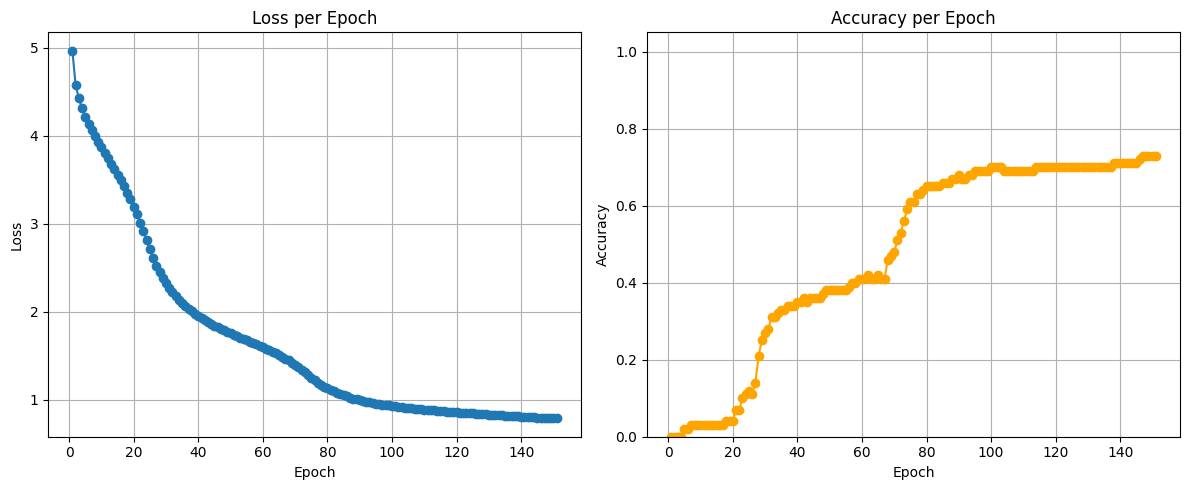

In [6]:
import numpy as np
import math
import os
from collections import OrderedDict
import matplotlib.pyplot as plt

# --- Configuration ---

input_sentences = [
    "i am", "they are", "she is", "we are", "you are", "he is",
    "it is", "i was", "they were", "we will", "you will", "he was",
    "she was", "i will", "they will", "we were", "he is not here"
    "we are going to", "you might be", "they could be",
    "i should have been", "you would be", "he shall be walking",
    "they will have been", "we might have been", "he was going to be",
    "she is currently", "i am still", "they are definitely", "you were probably",
    "we could have", "he will likely", "she might", "i will probably",
    "they were already", "we are soon", "you are still", "he was just",
    "she will surely", "i have been", "you had been", "he could be",
    "they might", "we were likely", "i was definitely", "she was just",
    "you are going to", "they have been", "we might be", "i could be",
    "she might have", "you shall be", "they are going to", "he was planning to",
    "we will be", "i am about to", "you were supposed to", "she was about to",
    "they are about to", "we are ready to", "he is expected to", "she is trying to",
    "you might want to", "i feel like", "they seem to be", "we hope to",
    "he pretends to", "she wants to", "i think i will", "you think you will",
    "they believe they will", "we assume we are", "he guesses he will", "she imagines she will",
    "i pretend to", "you imagine you will", "they plan to", "we are planning to",
    "he has decided to", "she intends to", "i am learning to", "you are starting to",
    "they are beginning to", "we are trying to", "he wants to start", "she is ready to",
    "i feel ready to", "you are expected to", "they are willing to", "we are prepared to",
    "he is committed to", "she is determined to", "i hope to", "you plan to",
    "they should", "we could", "he must", "she might want to",
    "i am going to", "you are going to", "we would be",
]
output_targets = [
    "sleeping", "playing", "dancing", "walking", "talking", "eating",
    "drawing", "reading", "coding", "running", "jumping", "writing",
    "building", "painting", "traveling", "learning", "talking",
    "dancing", "walking", "sleeping",
    "reading", "coding", "running", "jumping", "writing", "building",
    "painting", "traveling", "learning", "reading",
    "talking", "dancing", "walking", "sleeping", "playing", "dancing",
    "walking", "talking", "eating", "drawing", "reading", "coding",
    "running", "jumping", "writing", "building", "painting", "traveling",
    "learning", "reading", "talking", "dancing", "walking", "sleeping",
    "playing", "dancing", "walking", "talking", "eating", "drawing",
    "reading", "coding", "running", "jumping", "writing", "building",
    "painting", "traveling", "learning", "reading", "talking", "dancing",
    "walking", "sleeping", "playing", "dancing", "walking", "talking",
    "eating", "drawing", "reading", "coding", "running", "jumping",
    "writing", "building", "painting", "traveling", "learning", "reading",
    "talking", "dancing", "walking", "sleeping", "playing", "dancing",
    "walking", "talking", "eating", "drawing"
]

assert len(input_sentences)==len(output_targets)

embedding_dim = 512  # Keeping original embedding dimension
learning_rate = 0.01
num_epochs = 5000 # Increased epochs to ensure overfitting on small data

# --- Helper Functions ---

def clip_gradient(grad, threshold=1.0):
    """Clips gradients to prevent exploding gradients."""
    norm = np.linalg.norm(grad)
    if norm > threshold:
        return grad * (threshold / (norm + 1e-6))
    return grad

def softmax(x, axis=-1):
    """Computes softmax probabilities."""
    # Subtract max for numerical stability
    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

class LayerNormalization:
    """
    Implements Layer Normalization.
    Reference: https://arxiv.org/abs/1607.06450
    """
    def __init__(self, features_dim):
        self.gamma = np.ones(features_dim)
        self.beta = np.zeros(features_dim)
        self.eps = 1e-9

        # Stored for backward pass
        self.mean = None
        self.variance = None
        self.x_normalized = None
        self.x_input = None
        self.features_dim = features_dim # Store features_dim explicitly

    def forward(self, x):
        self.x_input = x
        self.mean = np.mean(x, axis=-1, keepdims=True)
        self.variance = np.var(x, axis=-1, keepdims=True)
        self.x_normalized = (x - self.mean) / np.sqrt(self.variance + self.eps)
        return self.gamma * self.x_normalized + self.beta

    def backward(self, dout):
        # Gradients for beta and gamma
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(dout * self.x_normalized, axis=0)

        # Gradient for x_normalized
        dx_normalized = dout * self.gamma

        # Number of elements in the dimension over which mean/variance was computed
        # For LayerNorm, this is typically the feature dimension (embedding_dim)
        N = self.features_dim

        # Gradient of variance
        d_var = np.sum(dx_normalized * (self.x_input - self.mean), axis=-1, keepdims=True) * (-0.5 * (self.variance + self.eps)**(-1.5))

        # Gradient of mean
        d_mean = np.sum(dx_normalized * (-1.0 / np.sqrt(self.variance + self.eps)), axis=-1, keepdims=True) + \
                 d_var * np.sum(-2.0 * (self.x_input - self.mean) / N, axis=-1, keepdims=True)

        # Gradient of x
        dx = dx_normalized / np.sqrt(self.variance + self.eps) + \
             d_var * (2.0 * (self.x_input - self.mean) / N) + \
             d_mean / N

        return dx, dgamma, dbeta

def positional_encoding(sequence_length, embedding_dim):
    """
    Computes positional encodings for a sequence.
    PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    position_enc = np.zeros((sequence_length, embedding_dim))
    for pos in range(sequence_length):
        for i in range(embedding_dim):
            denominator = 10000 ** (i / embedding_dim)
            if i % 2 == 0:
                position_enc[pos, i] = math.sin(pos / denominator)
            else:
                position_enc[pos, i] = math.cos(pos / denominator)
    return position_enc

# --- Model Components (Simplified for this example) ---

class SelfAttention:
    """Single head self-attention mechanism."""
    def __init__(self, embedding_dim, sequence_length):
        # Initialize weights for Query, Key, Value, and Output projection
        self.WQ = np.random.randn(embedding_dim, embedding_dim) * 0.01
        self.WK = np.random.randn(embedding_dim, embedding_dim) * 0.01
        self.WV = np.random.randn(embedding_dim, embedding_dim) * 0.01
        self.W0 = np.random.randn(embedding_dim, embedding_dim) * 0.01 # Output projection

        # Stored for backward pass
        self.Q = None
        self.K = None
        self.V = None
        self.scores = None
        self.weights = None
        self.attention = None
        self.X_input = None # Store input X for backward pass

    def forward(self, X):
        self.X_input = X # Store original input
        self.Q = X @ self.WQ
        self.K = X @ self.WK
        self.V = X @ self.WV

        # Scaled Dot-Product Attention
        self.scores = (self.Q @ self.K.T) / np.sqrt(embedding_dim) # Using embedding_dim as d_k
        self.weights = softmax(self.scores, axis=-1)
        self.attention = self.weights @ self.V

        # Output projection
        attention_out = self.attention @ self.W0
        return attention_out

    def backward(self, dout_attention_out):
        # Gradients for W0X
        dW0 = self.attention.T @ dout_attention_out

        # Gradient for attention
        dout_attention = dout_attention_out @ self.W0.T

        # Gradients for V and weights
        dV = self.weights.T @ dout_attention
        dweights = dout_attention @ self.V.T

        # Gradient for scores (softmax backward)
        dscores = dweights * self.weights
        sum_dscores = np.sum(dscores, axis=-1, keepdims=True)
        dscores -= self.weights * sum_dscores
        dscores /= np.sqrt(embedding_dim) # Divide by sqrt(d_k) from forward pass

        # Backprop through scores = (Q @ K.T) / sqrt(d_k)
        # Let S_unscaled = Q @ K.T
        d_S_unscaled = dscores * np.sqrt(embedding_dim)

        # For S_unscaled = Q @ K.T:
        # dL/dQ = dL/dS_unscaled @ K.T.T = dL/dS_unscaled @ K
        # dL/dK = (Q.T @ dL/dS_unscaled).T = dL/dS_unscaled.T @ Q
        dQ = d_S_unscaled @ self.K
        dK = d_S_unscaled.T @ self.Q

        # Gradients for WQ, WK, WV
        dWQ = self.X_input.T @ dQ
        dWK = self.X_input.T @ dK
        dWV = self.X_input.T @ dV

        # Gradient for X (input to attention)
        dX = dQ @ self.WQ.T + dK @ self.WK.T + dV @ self.WV.T

        # Clip gradients before returning
        dWQ = clip_gradient(dWQ)
        dWK = clip_gradient(dWK)
        dWV = clip_gradient(dWV)
        dW0 = clip_gradient(dW0)
        dX = clip_gradient(dX)

        return dX, dWQ, dWK, dWV, dW0

class FeedForwardNetwork:
    """Simple two-layer feed-forward network with ReLU activation."""
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros(output_dim)

        # Stored for backward pass
        self.in_for_relu = None
        self.FFN_hidden = None
        self.input_X = None # Store input X for backward pass

    def forward(self, X):
        self.input_X = X
        self.in_for_relu = X @ self.W1 + self.b1
        self.FFN_hidden = np.maximum(0, self.in_for_relu) # ReLU activation
        FFN_output = self.FFN_hidden @ self.W2 + self.b2
        return FFN_output

    def backward(self, dout_ffn_output):
        # Gradients for W2 and b2
        dW2 = self.FFN_hidden.T @ dout_ffn_output
        db2 = np.sum(dout_ffn_output, axis=0)

        # Gradient for FFN_hidden (before ReLU)
        dout_ffn_hidden = dout_ffn_output @ self.W2.T

        # Gradient for in_for_relu (ReLU backward)
        drelu = dout_ffn_hidden * (self.in_for_relu > 0).astype(float)

        # Gradients for W1 and b1
        dW1 = self.input_X.T @ drelu
        db1 = np.sum(drelu, axis=0)

        # Gradient for X (input to FFN)
        dX = drelu @ self.W1.T

        # Clip gradients before returning
        dW1 = clip_gradient(dW1)
        db1 = clip_gradient(db1)
        dW2 = clip_gradient(dW2)
        db2 = clip_gradient(db2)
        dX = clip_gradient(dX)

        return dX, dW1, db1, dW2, db2

# --- Transformer Model Class ---

class SimpleTransformer:
    def __init__(self, vocab, embedding_dim, hidden_dim):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Word embeddings
        self.word_to_vec = {word: np.random.randn(embedding_dim) * 0.01 for word in vocab}
        # Normalize embeddings
        for k in self.word_to_vec:
            self.word_to_vec[k] /= np.linalg.norm(self.word_to_vec[k]) + 1e-9

        # Model layers
        self.attention_layer = SelfAttention(embedding_dim, embedding_dim)
        self.norm1 = LayerNormalization(embedding_dim)
        self.ffn = FeedForwardNetwork(embedding_dim, hidden_dim, embedding_dim)
        self.norm2 = LayerNormalization(embedding_dim)

        # Output layer weights (projection from sentence vector to vocabulary logits)
        self.V_output = np.array([self.word_to_vec[word] for word in vocab])
        self.max_seq_len = 5 # Define max_seq_len here, consistent with forward

    def forward(self, input_text):
        words = input_text.split()

        # Store original length before padding
        original_input_len = len(words)

        # Pad or truncate to a fixed sequence length (e.g., 5 for simplicity)
        max_seq_len = self.max_seq_len
        if original_input_len < max_seq_len:
            words.extend(['<PAD>'] * (max_seq_len - original_input_len))
        elif original_input_len > max_seq_len:
            words = words[:max_seq_len]

        # Get embeddings for input words
        input_embeddings = np.array([self.word_to_vec[word] if word in self.word_to_vec else self.word_to_vec['<UNK>'] for word in words])

        # Add positional encoding
        pos_enc = positional_encoding(len(words), self.embedding_dim)
        X = input_embeddings + pos_enc

        # Encoder Block
        # Self-Attention
        attention_out = self.attention_layer.forward(X)

        # Add & Norm 1
        add_norm1_input = X + attention_out
        norm1_output = self.norm1.forward(add_norm1_input)

        # Feed Forward Network
        ffn_output = self.ffn.forward(norm1_output)

        # Add & Norm 2
        add_norm2_input = norm1_output + ffn_output
        norm2_output = self.norm2.forward(add_norm2_input)

        # Sentence vector: Average of non-padding token representations
        # Use original_input_len to average only actual input words
        if original_input_len > 0:
            sentence_vector = np.mean(norm2_output[:original_input_len], axis=0)
        else:
            sentence_vector = np.zeros(self.embedding_dim)

        # Final projection to vocabulary logits
        logits = self.V_output @ sentence_vector
        probs = softmax(logits)

        return probs, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, words # Return padded words

    def backward(self, probs, target_word, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, current_input_idx):
        target_index = self.vocab.index(target_word)

        # Initialize gradients for word embeddings
        d_word_to_vec = {word: np.zeros(self.embedding_dim) for word in self.vocab}

        # --- Gradients from Output Layer (V_output) ---
        dlogits = probs.copy()
        dlogits[target_index] -= 1

        dV_output = np.outer(dlogits, sentence_vector)

        # Accumulate gradients for word_to_vec from V_output
        for i, word in enumerate(self.vocab):
            d_word_to_vec[word] += dV_output[i]

        # Gradient for sentence_vector
        dsentence_vector = self.V_output.T @ dlogits

        # --- Backprop through Sentence Vector Averaging ---
        # Distribute dsentence_vector equally to the averaged elements
        dnorm2_output_from_sentence_vec = np.zeros_like(add_norm2_input)
        if original_input_len > 0:
            dnorm2_output_from_sentence_vec[:original_input_len] = dsentence_vector / original_input_len

        # --- Backprop through Transformer Encoder ---
        # The total gradient for norm2_output is dnorm2_output_from_sentence_vec
        dnorm2_output = dnorm2_output_from_sentence_vec

        dadd_norm2_input, dgamma2, dbeta2 = self.norm2.backward(dnorm2_output)
        self.norm2.gamma -= learning_rate * dgamma2
        self.norm2.beta -= learning_rate * dbeta2

        dffn_output = dadd_norm2_input
        dx_ffn, dW1, db1, dW2, db2 = self.ffn.backward(dffn_output)
        self.ffn.W1 -= learning_rate * dW1
        self.ffn.b1 -= learning_rate * db1
        self.ffn.W2 -= learning_rate * dW2
        self.ffn.b2 -= learning_rate * db2

        dnorm1_output = dadd_norm2_input + dx_ffn
        dadd_norm1_input, dgamma1, dbeta1 = self.norm1.backward(dnorm1_output)
        self.norm1.gamma -= learning_rate * dgamma1
        self.norm1.beta -= learning_rate * dbeta1

        dattention_out = dadd_norm1_input
        dx_attention, dWQ, dWK, dWV, dW0 = self.attention_layer.backward(dattention_out)
        self.attention_layer.WQ -= learning_rate * dWQ
        self.attention_layer.WK -= learning_rate * dWK
        self.attention_layer.WV -= learning_rate * dWV
        self.attention_layer.W0 -= learning_rate * dW0

        # Gradient for input embeddings (dL/dX)
        dL_by_dX = dadd_norm1_input + dx_attention

        # Accumulate gradients for word_to_vec from input embeddings
        # Use min(len(original_input_words), self.max_seq_len) to ensure
        # we only iterate over the actual part of dL_by_dX that corresponds
        # to the input words (truncated or padded).
        original_input_words = input_sentences[current_input_idx].split()
        for j in range(min(len(original_input_words), self.max_seq_len)):
            word = original_input_words[j]
            if word in self.vocab:
                d_word_to_vec[word] += dL_by_dX[j]
            # Handle cases where original_input_words[j] might be truncated,
            # but its embedding was still used in the forward pass.
            # This is implicitly handled by dL_by_dX being the gradient for X,
            # which includes the embeddings for all max_seq_len tokens.
            # For words that were truncated, their contribution to X
            # is effectively zero in the dL_by_dX calculation from later layers.

        # --- Apply accumulated gradients to word embeddings ---
        for word in self.vocab:
            if np.linalg.norm(d_word_to_vec[word]) > 0:
                self.word_to_vec[word] -= learning_rate * d_word_to_vec[word]
                # Re-normalize after update
                self.word_to_vec[word] /= np.linalg.norm(self.word_to_vec[word]) + 1e-9

        # Update V_output matrix to reflect changes in word_to_vec
        self.V_output = np.array([self.word_to_vec[word] for word in self.vocab])


# --- Main Training Loop ---

# Build a minimal vocabulary from the provided data
all_words = set()
for sentence in input_sentences:
    all_words.update(sentence.split())
for word in output_targets:
    all_words.add(word)

# Add special tokens
special_tokens = ['<END>', '<PAD>', '<START>', '<UNK>']
for token in special_tokens:
    all_words.add(token)

vocab = sorted(list(all_words))
vocab_size = len(vocab)
vocab_to_id = {word: i for i, word in enumerate(vocab)} # Create a mapping from word to ID
print(f"Vocabulary: {vocab}")
print(f"Vocabulary Size: {vocab_size}")

# Initialize the model
model = SimpleTransformer(vocab, embedding_dim, hidden_dim=2048)

# Lists to store metrics for plotting
epoch_losses = []
epoch_accuracies = []

# Define column widths for better formatting
COL_WIDTHS = {
    'Epoch': 6,
    'Original Input': 30,
    'Padded Tokens': 50, # Increased width for list representation
    'Padded IDs': 35,    # Increased width for list representation
    'Target': 10,
    'Target ID': 10,
    'Predicted': 10,
    'Predicted ID': 12,
    'Loss': 12,
    'Correct Prediction': 20 # Renamed and adjusted width
}

# Print table header
header_parts = [
    'Epoch'.ljust(COL_WIDTHS['Epoch']),
    'Original Input'.ljust(COL_WIDTHS['Original Input']),
    'Padded Tokens'.ljust(COL_WIDTHS['Padded Tokens']),
    'Padded IDs'.ljust(COL_WIDTHS['Padded IDs']),
    'Target'.ljust(COL_WIDTHS['Target']),
    'Target ID'.ljust(COL_WIDTHS['Target ID']),
    'Predicted'.ljust(COL_WIDTHS['Predicted']),
    'Predicted ID'.ljust(COL_WIDTHS['Predicted ID']),
    'Loss'.ljust(COL_WIDTHS['Loss']),
    'Correct Prediction'.ljust(COL_WIDTHS['Correct Prediction']) # Renamed header
]

# Training loop
for epoch in range(1, num_epochs + 1):
    total_loss = 0
    correct_predictions = 0

    for current_input_idx in range(len(input_sentences)):
        input_text = input_sentences[current_input_idx]
        target_word = output_targets[current_input_idx]

        # Forward pass - now also returns 'padded_words_list'
        probs, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, padded_words_list = model.forward(input_text)

        # Get padded input token IDs
        padded_input_token_ids = [vocab_to_id[token] if token in vocab_to_id else vocab_to_id['<UNK>'] for token in padded_words_list]

        # Get target token ID
        target_token_id = vocab_to_id[target_word] if target_word in vocab_to_id else vocab_to_id['<UNK>']

        # Calculate loss
        target_index = model.vocab.index(target_word)
        loss = -np.log(probs[target_index] + 1e-9)

        # Backward pass (update model parameters)
        model.backward(probs, target_word, sentence_vector, input_embeddings, X, norm1_output, add_norm1_input, add_norm2_input, original_input_len, current_input_idx)

        # Get prediction
        predicted_index = np.argmax(probs)
        predicted_word = model.vocab[predicted_index]
        predicted_token_id = vocab_to_id[predicted_word] # Get predicted token ID

        total_loss += loss
        if predicted_word == target_word:
            correct_predictions += 1
            current_correct_prediction = "Yes" # Changed to "Yes"
        else:
            current_correct_prediction = "No" # Changed to "No"

        # Format each part of the row using ljust/rjust

        if epoch%10==0 and current_input_idx==0:
          print(" | ".join(header_parts))
          print("-" * (sum(COL_WIDTHS.values()) + len(COL_WIDTHS) * 3 - 3)) # Calculate total width of separator

        if epoch%10==0:
          row_parts = [
              str(epoch).ljust(COL_WIDTHS['Epoch']),
              input_text.ljust(COL_WIDTHS['Original Input']),
              str(padded_words_list).ljust(COL_WIDTHS['Padded Tokens']),
              str(padded_input_token_ids).ljust(COL_WIDTHS['Padded IDs']),
              target_word.ljust(COL_WIDTHS['Target']),
              str(target_token_id).ljust(COL_WIDTHS['Target ID']),
              predicted_word.ljust(COL_WIDTHS['Predicted']),
              str(predicted_token_id).ljust(COL_WIDTHS['Predicted ID']),
              f"{loss:.4f}".rjust(COL_WIDTHS['Loss']), # Right-align loss and format
              current_correct_prediction.ljust(COL_WIDTHS['Correct Prediction']) # Updated column
          ]
          print(" | ".join(row_parts))

    # Calculate epoch-level metrics
    epoch_avg_loss = total_loss / len(input_sentences)
    epoch_accuracy = correct_predictions / len(input_sentences)
    epoch_losses.append(epoch_avg_loss)
    epoch_accuracies.append(epoch_accuracy)

    # Print epoch summary
    print(f"Epoch {epoch} Summary: Average Loss = {epoch_avg_loss:.4f}, Accuracy = {epoch_accuracy:.2f}")

    # Check for convergence (e.g., if all predictions are correct and loss is low)
    if correct_predictions == len(input_sentences) and total_loss < 0.01:
        print("\nModel converged! Overfitting successful.")
        break

    if epoch>150:
      print("Stopping the training....")
      break

print("-" * (sum(COL_WIDTHS.values()) + len(COL_WIDTHS) * 3 - 3)) # Calculate total width of separator
print("\nTraining complete.")

# --- Plotting Loss and Accuracy ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, marker='o', linestyle='-', color='orange')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05) # Ensure y-axis goes from 0 to 1
plt.grid(True)

plt.tight_layout()
plt.show()